In [1]:
from sat_initial import *

In [2]:
from datastructures.api import (edges_no_param, addobj, addineq, OPT, SolverRef, merge, 
copy_dicts, setsolvefor, var_params)
from datastructures.graphutils import flatten_tree, all_variables, all_edges
from datastructures.tearing import dir_graph, min_arc_set_assign
from datastructures.operators import reformulate, invert_edges
from datastructures.rendering import render_incidence
from datastructures.runpipeline import (model_to_problem, order_from_tree, 
    default_solver_options, mdao_workflow)
from datastructures.postprocess import print_outputs, print_inputs, update_varval
from datastructures.transformations import transform_components
import openmdao.api as om
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Configuration

In [3]:
global run_optimal_structure
def f(optimal_structure):
    global run_optimal_structure
    run_optimal_structure=optimal_structure
interact(f, optimal_structure=True);

interactive(children=(Checkbox(value=True, description='optimal_structure'), Output()), _dom_classes=('widget-…

### Load structure of model

In [4]:
edges, tree = model.generate_formulation()
edges_nopar =  edges_no_param(model, edges)
outset_initial = {comp: var[0] for comp,var in edges[1].items()}

### Restructure design model

We force variables from the constraints to be inputs: $L_t, X_r, EN, h, m_s$

In [5]:
not_input = {'H_{val}', r'\rho_{val}', 'm_p'}#['m_p']#'d', r'\rho_{val}', 'L_p', 'H_{val}']
not_output = {'L_t','X_r','EN', 'h', 'm_s'}#['h']#[r'm_{rz}', 'm_{r0}']
edges_for_solving = copy_dicts(edges_nopar)
eqnidxs = list(edges_for_solving[1].keys())
varidxs = all_variables(*edges_for_solving)
graph_edges_minassign = all_edges(*edges_for_solving)
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_input, not_output)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


### Build structure of optimization model

In [6]:
outset_opt = None
if run_optimal_structure:
    outset_opt = {right:left for left, right in edges_left_right if (left,right) in edges_left_right and xsol[left, right] > 0.5}

In [7]:
tree_for_reformulation = flatten_tree(tree, 'opt')
not_outputs = var_params(model, edges)
edges_minassign, tree_minassign = reformulate(edges, tree_for_reformulation, outset_initial, 
                                              outset_opt, root_solver_name='opt', solveforvars=False, mdf=True) # For OPT do not have subproblems so no need to set mdf=True/False
edges_minassign_noparam = edges_no_param(model, edges_minassign)

In [8]:
newcomps = transform_components(edges, edges_minassign, model.components, model.idmapping)

In [9]:
newcomps

[(('Q', '\\eta_A', 'P_c', 'd'), 6, ('A',), 'P_c/(Q*\\eta_A*d)'),
 (('P_T', 'P_l'), 7, ('P_c',), 'P_l + P_T'),
 (('T', 'E_b', 'P_c', 'd'), 8, (None,), 'E_b - P_c*T/d'),
 (('m_b', '\\rho_b'), 9, ('E_b',), 'm_b/\\rho_b'),
 (('r', 'EN', 'G_T', '\\lambda_c', 'b', 'G_r', 'k', 'T_s', 'L'), 18, ('P_T',), '157.91367041743*L*T_s*k*EN*b*r**2/(G_T*G_r*\\lambda_c**2)'),
 (('m_s', '\\eta_S'), 19, ('m_t',), 'm_s/\\eta_S'),
 (('m_t', 'm_p', 'm_{pr}', 'm_s', 'm_T', 'm_A'), 20, ('m_b',), '-m_A - m_T - m_p - m_s + m_t - m_{pr}'),
 (('L_p', '\\rho_{val}', 'a', 'G', '\\mu', 'C_D', 'Isp', 'A'), 24, ('m_{pr}',), '0.5*C_D*\\mu*A*L_p*\\rho_{val}/(G*Isp*a)'),
 (('L_n', 'L_t'), 25, ('L_p',), '-L_n + L_t')]

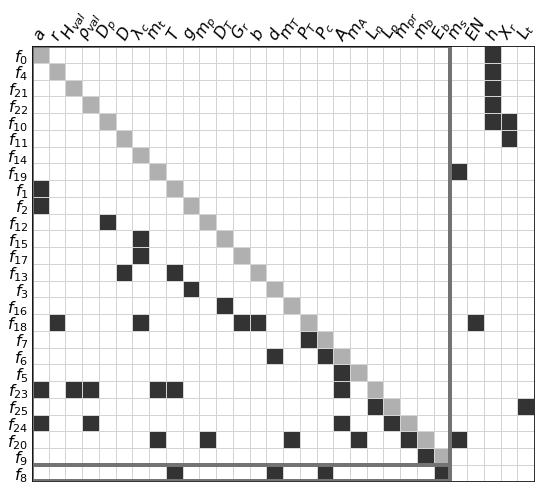

In [10]:
_, ax = render_incidence(edges_minassign_noparam, tree_minassign, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)))

### Optimization formulation

In [11]:
opt = addsolver(m, name="opt", idbyname=True)

In [12]:
ENreq = Par('EN_r', 14.125)
addineq(opt, -Lt+L_min)
addineq(opt, -EN+ENreq)
addobj(opt, mt)

In [13]:
solvefor_init = [A,m_pr]
varoptions_init = {A:[0,10], m_pr:[0,10]}

In [14]:
solvefor_opt = [m_s, Lt, EN]
varoptions_opt = {}

In [15]:
solvefor, varoptions = ((solvefor_init, varoptions_init), (solvefor_opt, varoptions_opt))[run_optimal_structure]
setsolvefor(opt, solvefor, varoptions)
model.solvers_options['opt'] = {'type': OPT}#, 'optimizer': 'IPOPT', 'driver': om.pyOptSparseDriver}

In [16]:
formulation = model.generate_formulation()
edges_ma_opt, tree_ma_opt = merge(formulation, edges_minassign, 
                                  tree_minassign, copysolvers=False)
edges_ma_opt_noparam = edges_no_param(model, edges_ma_opt)

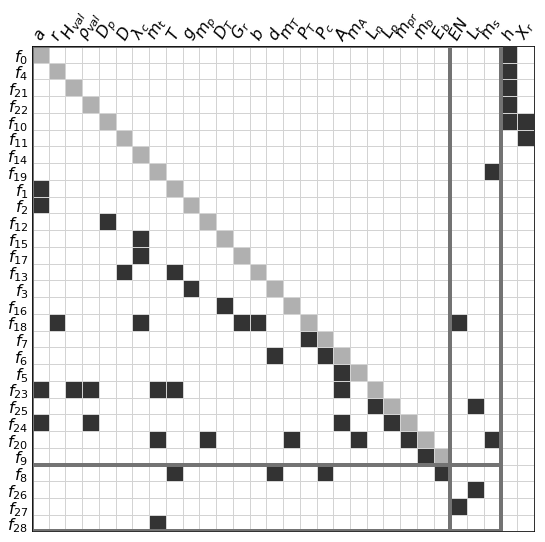

In [17]:
_, ax = render_incidence(edges_ma_opt_noparam, tree_ma_opt, rawvarname=True, 
                         dispendcomp=False, hideticks=True, patchwidth=4, figsize=((9,9)))

In [18]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, 
                        formulation=(edges_ma_opt, tree_ma_opt),
                        components=model.components+newcomps)

In [19]:
prob.set_val('L_t', 10)
prob.set_val('h', 400)
prob.set_val('EN', 14.125)
prob.set_val('X_r', 5)

In [20]:
prob.run_driver()

Optimization terminated successfully    (Exit mode 0)
            Current function value: [5.80754331]
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization Complete
-----------------------------------


False

In [29]:
print_outputs(model, prob, namingfunc, rounding=3)

$$a$$,6778,km
$$T$$,92.558,min
$$g$$,0.11,
$$d$$,0.61,
$$r$$,2293.992,km
$$m_A$$,0.509,kg
$$P_c$$,12.725,W
$$P_T$$,0.725,W
$$E_b$$,115.866,kJ
$$m_b$$,0.232,kg
$$D_p$$,0.049,m
